In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.stats as stats
import warnings
import json
from itertools import combinations

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

In [8]:
def categorize_numerical_col(col_name, bins, bins_name):
    new_col = f'{col_name}_categorized'
    df[new_col] = pd.cut(df[col_name], bins=bins, labels=bins_name)


def categorical_tests(test_type="vs-target", data=None, column=None, target=None, alpha=0.05):

    if test_type == "vs-target":
        con_table = pd.crosstab(data[column], data[target])
        stat, p_value, degree, _ = stats.chi2_contingency(con_table)
        result = {
            "categories vs target":test_type, "chi2_stat": stat, "p_value": p_value,
            "degrees_of_freedom": degree,
            "contingency_table": con_table.to_dict()
        }
        print('='*48)
        print(json.dumps(result, indent=3, sort_keys=False, default=str)) # using json.dumps for prettier printing
        print('='*40)

    elif test_type == "vs-categories":
        categories = df[column].unique()
        category_pairs = list(combinations(categories, 2))
        result = []
        for group1, group2 in category_pairs:
            subset = df[df[column].isin([group1, group2])]
            contingency_table = pd.crosstab(subset[column], subset[target])
            chi2, p_value, degree, _ = stats.chi2_contingency(contingency_table)

            if p_value < alpha:
                print(f"Significant difference between '{group1}' and '{group2}': \nChi2={chi2:.4f}, p-value={p_value:.4f}")
            else:
                print(f"No significant difference between '{group1}' and '{group2}': \nChi2={chi2:.4f}, p-value={p_value:.4f}")
        

def kpi_barplot(df, group_col, kpi = 'Conversion Rate'):
    
    if kpi not in ['Conversion Rate', 'CPC']:
        raise ValueError('The KPI value should either be "Conversion Rate" or "CPC"')
    
    tmp = df.groupby([group_col])[['Conversion', 'AdSpend']].agg(
        Conversion_mean=pd.NamedAgg(column='Conversion', aggfunc='mean'),
        Conversion_sum=pd.NamedAgg(column='Conversion', aggfunc='sum'),
        AdSpend=pd.NamedAgg(column='AdSpend', aggfunc='sum')
        ).reset_index()

    tmp.rename(columns={'Conversion_mean': 'Conversion Rate',
                        'AdSpend': 'Total AdSpend',
                        'Conversion_sum': 'Total Conversions'}, inplace=True)
    
    tmp['CPC'] = tmp['Total AdSpend'] / tmp['Total Conversions']
    tmp['Conversion Rate'] *= 100

    fig = plt.figure(figsize=(12, 7))
    ax = sns.barplot(
        data=tmp,
        x=group_col, 
        y=kpi,
        palette='viridis')
    ax.set_title(f'{kpi} by {group_col}')

    for p in ax.patches:
        string = f'{p.get_height():.2f}%' if kpi == 'Conversion Rate' else f'{p.get_height():.4f}$'
        ax.annotate(string,
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    fontsize=11, color='black',
                    xytext=(0, 10),
                    textcoords='offset points')
        

def draw_heatmap_groups(df, group1, group2, kpi='Conversion Rate'):
    if kpi not in ['Conversion Rate', 'CPC']:
        raise ValueError('The KPI value should either be "Conversion Rate" or "CPC"')
    
    tmp = df.groupby([group1, group2])[['Conversion', 'AdSpend']].agg(
        Conversion_mean=pd.NamedAgg(column='Conversion', aggfunc='mean'),
        Conversion_sum=pd.NamedAgg(column='Conversion', aggfunc='sum'),
        AdSpend=pd.NamedAgg(column='AdSpend', aggfunc='sum')
        ).reset_index()

    tmp.rename(columns={'Conversion_mean': 'Conversion Rate',
                        'AdSpend': 'Total AdSpend',
                        'Conversion_sum': 'Total Conversions'}, inplace=True)
    
    tmp['CPC'] = tmp['Total AdSpend'] / tmp['Total Conversions']
    tmp['Conversion Rate'] *= 100

    heatmap_data = tmp.pivot_table(
        index=group1,
        columns=group2,
        values=kpi
    )
    heatmap_data.fillna(0, inplace=True)
    plt.figure(figsize=(18, 8))
    sns.heatmap(
        heatmap_data,
        cmap='YlGnBu',
        annot=True,
        linewidths=0.7,
        linecolor='lightgray'

    )
    plt.title(f'Heatmap of Conversion Rate by {group1}/{group2}', fontsize=18, weight='bold')
    plt.show()


In [9]:
df = pd.read_csv('marketing.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2010 entries, 0 to 2009
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CustomerID           2010 non-null   int64  
 1   Age                  2010 non-null   int64  
 2   Gender               2010 non-null   object 
 3   Income               1931 non-null   float64
 4   CampaignChannel      1856 non-null   object 
 5   CampaignType         2010 non-null   object 
 6   AdSpend              2010 non-null   object 
 7   ClickThroughRate     2010 non-null   float64
 8   ConversionRate       2010 non-null   float64
 9   WebsiteVisits        2010 non-null   int64  
 10  PagesPerVisit        2010 non-null   float64
 11  TimeOnSite           1931 non-null   float64
 12  SocialShares         2010 non-null   int64  
 13  EmailOpens           2010 non-null   int64  
 14  EmailClicks          2010 non-null   int64  
 15  PreviousPurchases    2010 non-null   i

In [10]:
df.nunique()

CustomerID             2010
Age                      52
Gender                    2
Income                 1923
CampaignChannel           6
CampaignType              4
AdSpend                2010
ClickThroughRate       2010
ConversionRate         2010
WebsiteVisits            50
PagesPerVisit          2010
TimeOnSite             1931
SocialShares            100
EmailOpens               20
EmailClicks              23
PreviousPurchases        10
LoyaltyPoints          1659
AdvertisingPlatform       1
AdvertisingTool           1
Conversion                2
dtype: int64

Deleting variables which doesn't give us much info

In [11]:
df = df.drop(columns=['CustomerID', 'AdvertisingPlatform', 'AdvertisingTool'])

Time to clean up

In [12]:
df.isna().sum()

Age                    0
Gender                 0
Income                79
CampaignChannel      154
CampaignType           0
AdSpend                0
ClickThroughRate       0
ConversionRate         0
WebsiteVisits          0
PagesPerVisit          0
TimeOnSite            79
SocialShares           0
EmailOpens             0
EmailClicks            0
PreviousPurchases      0
LoyaltyPoints          0
Conversion             0
dtype: int64

In [13]:
df['CampaignChannel'] = df['CampaignChannel'].str.replace('email', 'Email')

In [14]:
df['CampaignChannel'] = df['CampaignChannel'].fillna('Other')

In [15]:
df['AdSpend'] = df['AdSpend'].astype(str).str.replace(r'[^\d\.]', '', regex=True).astype(float)


In [16]:
bins_AdSpend = [0, 2500, 5000, 7500, 10000]
bin_labels_AdSpend = ['Very Low Budget', 'Low Budget', 'Medium Budget', 'High Budget']
categorize_numerical_col('AdSpend', bins_AdSpend, bin_labels_AdSpend)


In [17]:
df['Income'].fillna(df['Income'].median(), inplace=True)

In [18]:
df['TimeOnSite'] = df.groupby(['WebsiteVisits'])['TimeOnSite'].transform(
    lambda x: x.fillna(x.mean())
)

In [19]:
df.head()


,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,PagesPerVisit,TimeOnSite,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,Conversion,AdSpend_categorized
0,36,Female,47648.0,Email,Consideration,893.755492,0.132078,0.198063,38,6.900081,11.923316,9,3,6,1,1139,1,Very Low Budget
1,32,Female,47491.0,Email,Consideration,7330.251375,0.120810,0.088416,27,4.589390,7.405528,33,0,2,4,3772,1,Medium Budget
2,52,Male,83830.0,Referral,Awareness,7720.360685,0.125472,0.082197,35,7.403157,0.660581,29,1,3,0,3611,1,High Budget
3,52,Male,116342.0,Social Media,Consideration,8337.453157,0.158739,0.089032,25,9.367090,12.218421,72,3,7,4,1173,1,High Budget
4,58,Female,90994.0,Email,Retention,5273.098832,0.226054,0.099792,13,7.968767,4.894079,41,16,7,0,1102,1,Medium Budget


-------------

<h1>Correlation of Columns</h1>

Let's see how the columns are correlated 

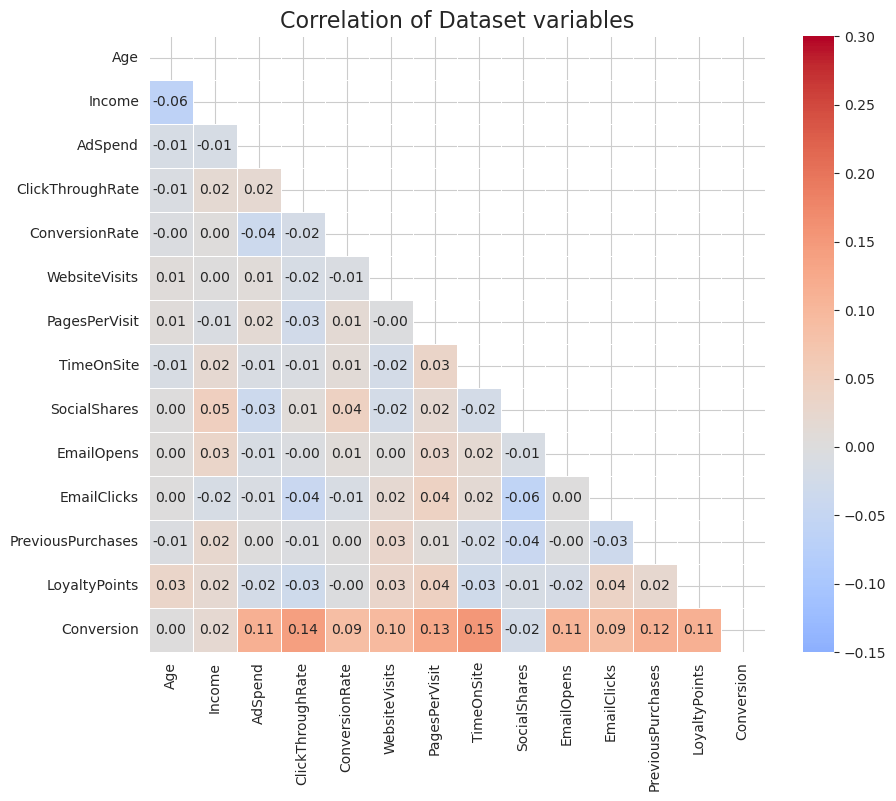

In [20]:
corr_mat = df.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr_mat, dtype=bool))
fig, ax = plt.subplots( figsize=(10,8) )
sns.heatmap(corr_mat, mask=mask,
            annot=True, center=0,
            linewidths=.5, square=True,
            vmin=-0.15, vmax=0.3, fmt='0.2f',cmap="coolwarm")
ax.set_title('Correlation of Dataset variables', fontsize=16)
fig.show()

As we can see from the heatmap, our variables are not hugely affecting each other. this means that every column can potentially give us information that others can't. another thing is we can see that some variables have more affect on our target variable "Conversion".

----------

<h1>KPI: Conversion Rate</h1>

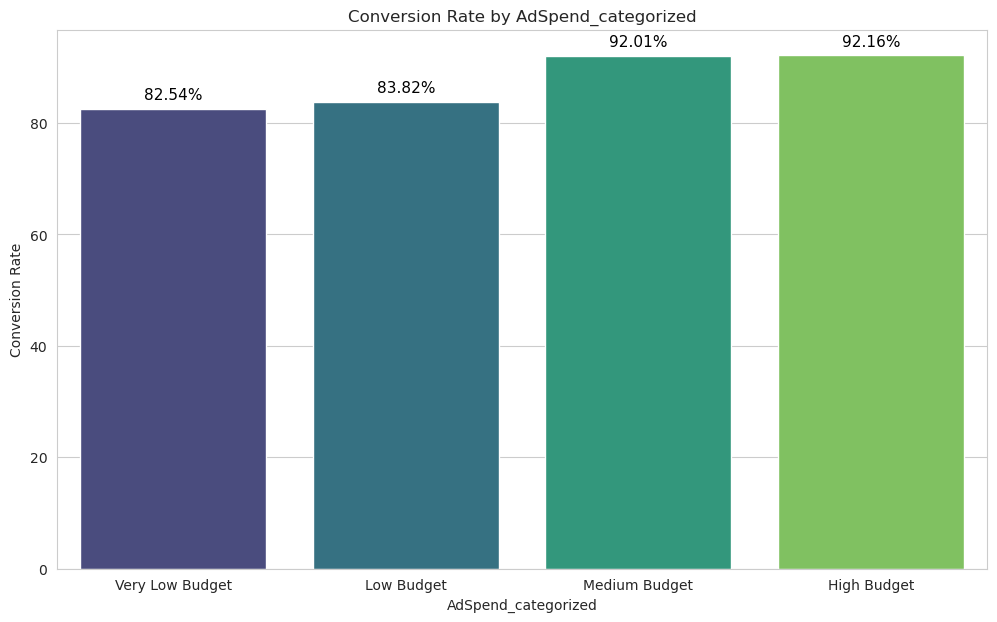

In [21]:
kpi_barplot(df=df, group_col='AdSpend_categorized')

In [22]:
categorical_tests(test_type="vs-categories", data=df, column='AdSpend_categorized', target='Conversion')

Significant difference between 'Very Low Budget' and 'Medium Budget': 
Chi2=20.0209, p-value=0.0000
Significant difference between 'Very Low Budget' and 'High Budget': 
Chi2=19.0497, p-value=0.0000
No significant difference between 'Very Low Budget' and 'Low Budget': 
Chi2=0.2077, p-value=0.6486
No significant difference between 'Medium Budget' and 'High Budget': 
Chi2=0.0000, p-value=1.0000
Significant difference between 'Medium Budget' and 'Low Budget': 
Chi2=16.0051, p-value=0.0001
Significant difference between 'High Budget' and 'Low Budget': 
Chi2=15.2941, p-value=0.0001


As we can see from the chi2 test between groups, we can regroup the AdSpend into two groups high and low.

In [23]:
bins_AdSpend = [0, 5000, np.inf]
bin_labels_AdSpend = ['<5K $', '>5K $']
categorize_numerical_col('AdSpend', bins_AdSpend, bin_labels_AdSpend)

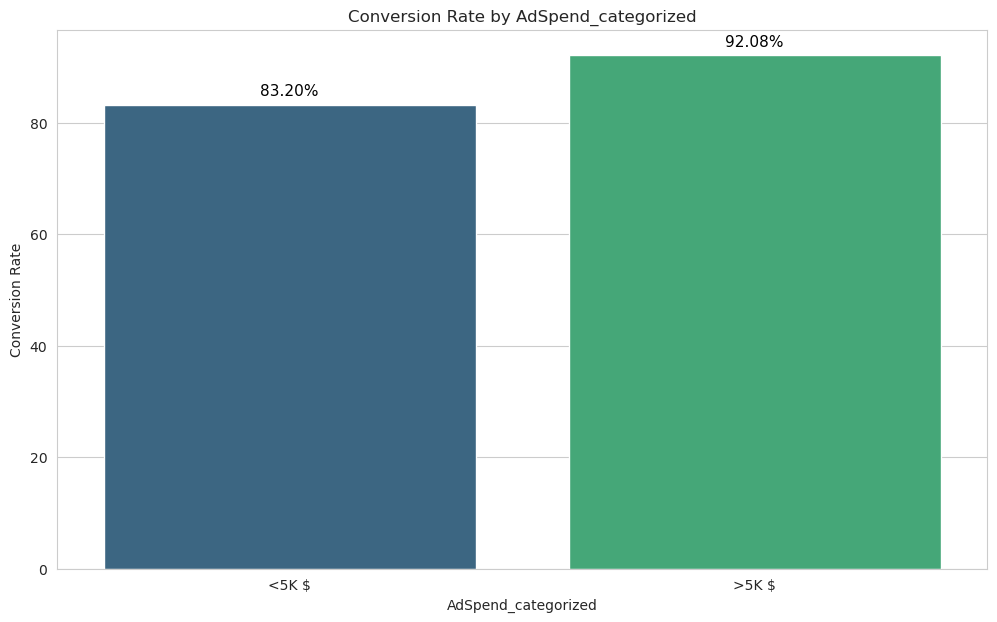

In [24]:
kpi_barplot(df, 'AdSpend_categorized')

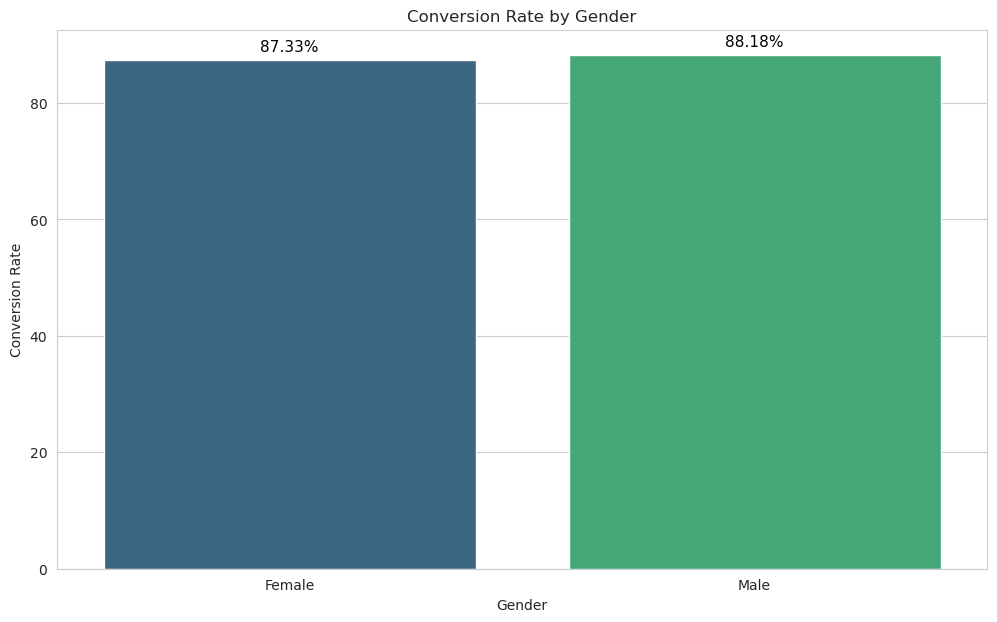

In [25]:
kpi_barplot(df, 'Gender')

As we can see the conversion rate between male and female users is fairly similar with maels being slightly higher.

In [26]:
bins = [18, 30, 45, 60, 70]
bin_labels = ['Young', 'Adult', 'Middle-Aged', 'Old']
categorize_numerical_col('Age', bins=bins, bins_name=bin_labels)

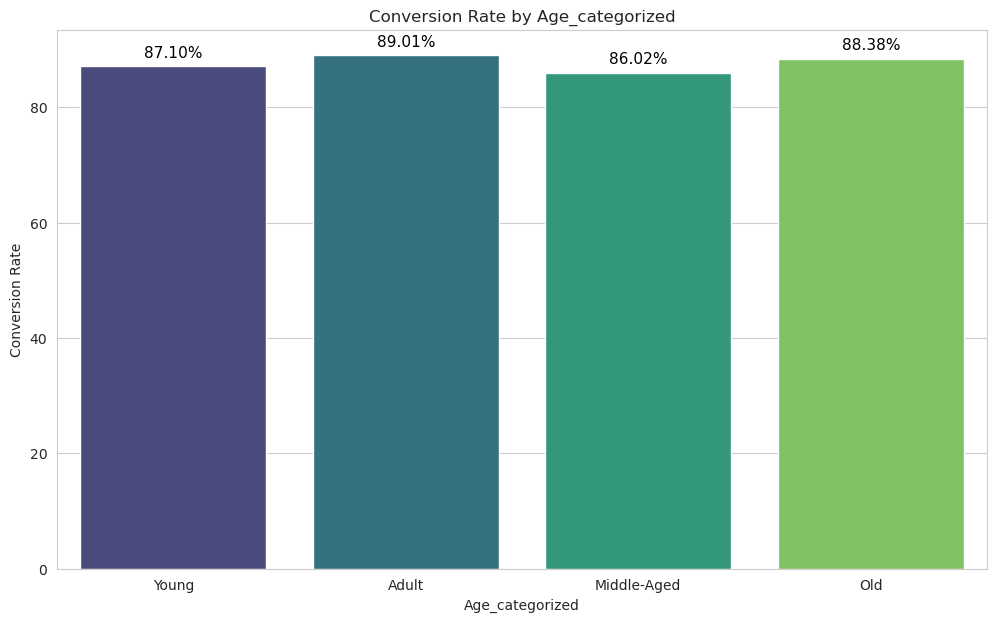

In [27]:
kpi_barplot(df, 'Age_categorized')

In [28]:
categorical_tests(test_type="vs-categories", data=df, column='Age_categorized', target='Conversion')

No significant difference between 'Adult' and 'Middle-Aged': 
Chi2=2.1518, p-value=0.1424
No significant difference between 'Adult' and 'Young': 
Chi2=0.7654, p-value=0.3817
No significant difference between 'Adult' and 'Old': 
Chi2=0.0347, p-value=0.8522
No significant difference between 'Adult' and 'nan': 
Chi2=0.0000, p-value=1.0000
No significant difference between 'Middle-Aged' and 'Young': 
Chi2=0.1726, p-value=0.6778
No significant difference between 'Middle-Aged' and 'Old': 
Chi2=0.8099, p-value=0.3681
No significant difference between 'Middle-Aged' and 'nan': 
Chi2=0.0000, p-value=1.0000
No significant difference between 'Young' and 'Old': 
Chi2=0.1844, p-value=0.6676
No significant difference between 'Young' and 'nan': 
Chi2=0.0000, p-value=1.0000
No significant difference between 'Old' and 'nan': 
Chi2=0.0000, p-value=1.0000


There is not much difference between age groups in terms of conversion rate.

!!!!What about age/gender group?

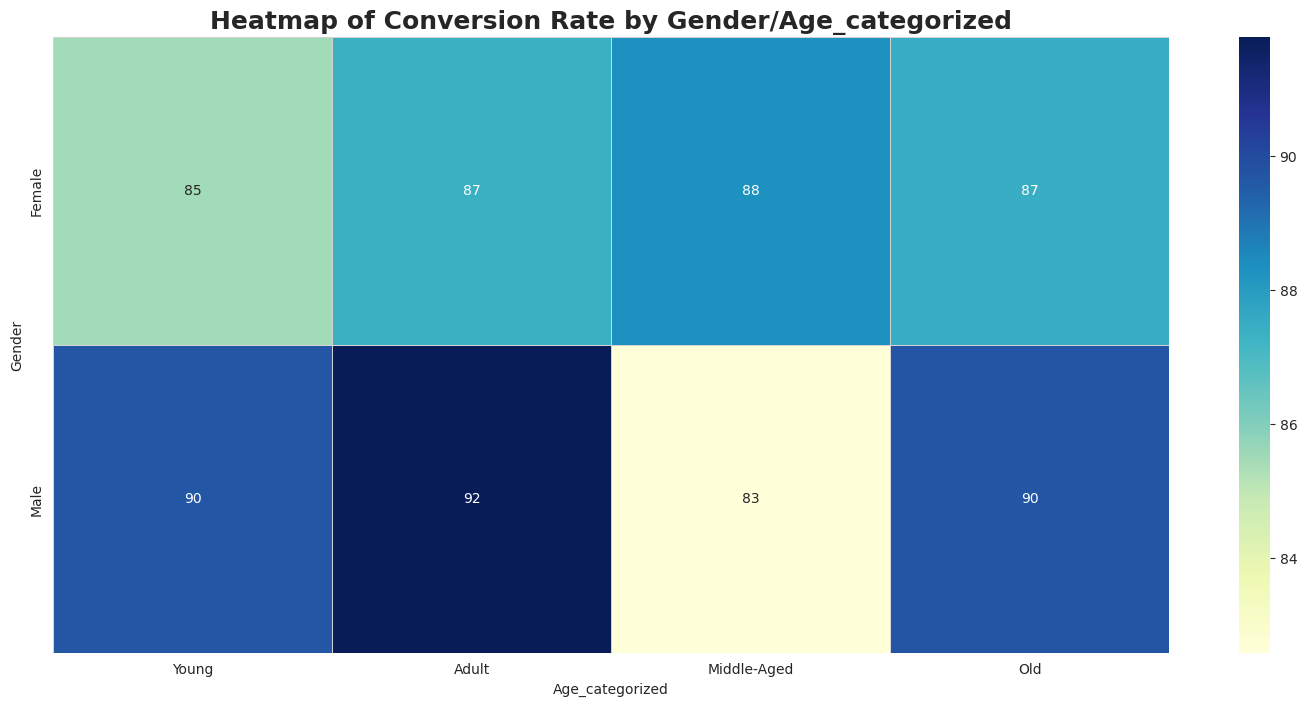

In [29]:
draw_heatmap_groups(df, 'Gender', 'Age_categorized')

As we can see here Adult Males has the highest conversion rate among male and in general,
while Middle-Aged Females has the highest conversion rate among females. another thing is that there is not much sudden change in female groups, as for male, there is more sudden group changes specially between adult and middle-aged

This map indicates that Middle-Aged males and Young females are two groups that the company should be working harder on.

We can also use strip plots to analyse some data.

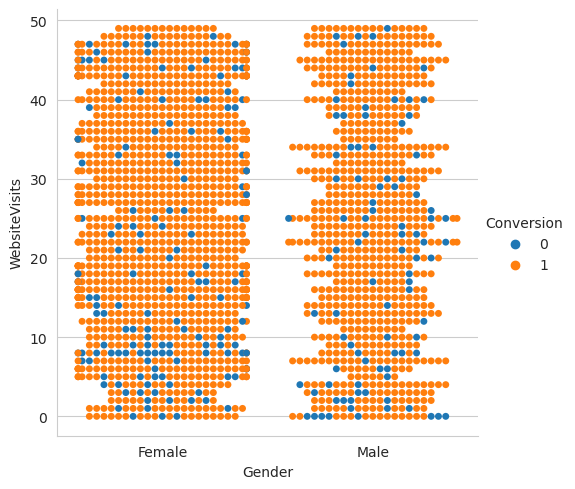

In [35]:
sns.catplot(data=df, x="Gender", y="WebsiteVisits", hue="Conversion", kind="swarm")

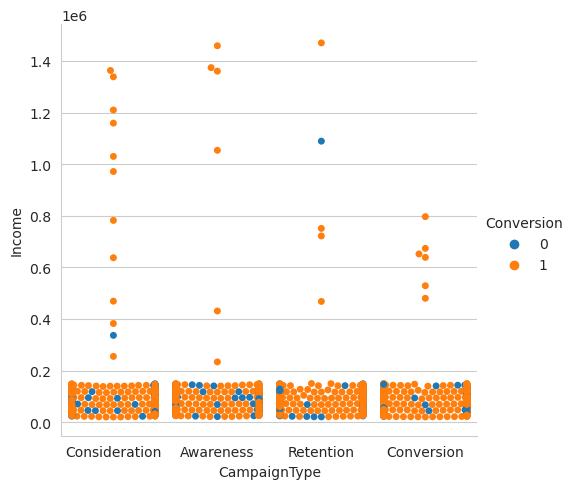

In [34]:
sns.catplot(data=df, x="CampaignType", y="Income", hue="Conversion", kind="swarm")

Not much can be deducted from these plots

----------

Let's see if CampaignChannel has effects in different age/gender groups.

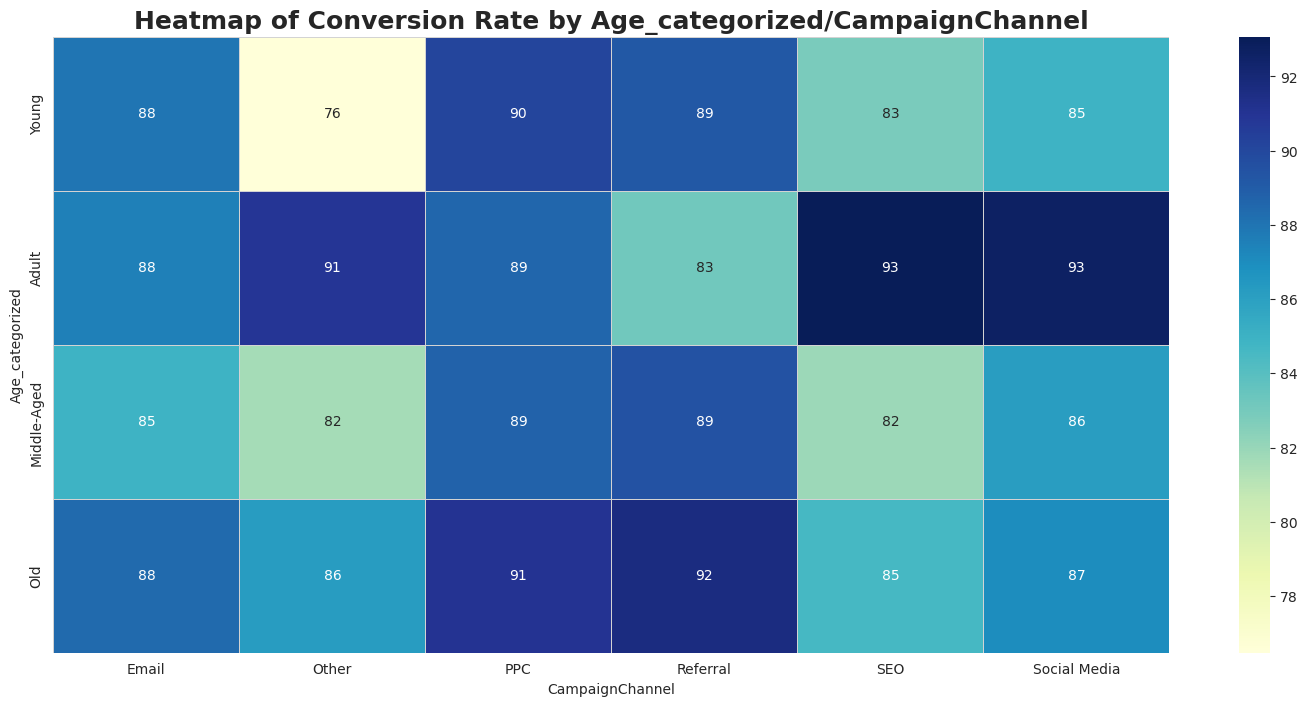

In [218]:
draw_heatmap_groups(df, 'Age_categorized', 'CampaignChannel')

here we can see that Social Media, SEO and Other groups have been very popular between adults. If you recall we fill the nan value of campaign channel with other. this map might be an indication that other group could be the combination of social media and seo group because it has very similar behavior in adult, middle-aged and old groups.

other than that, we can see PPC and Referral champaign are dominating the old groups an also very popular in young groups too. Email Campaign has a fairly similar behavior in all the age groups with middle-aged being the lowest.

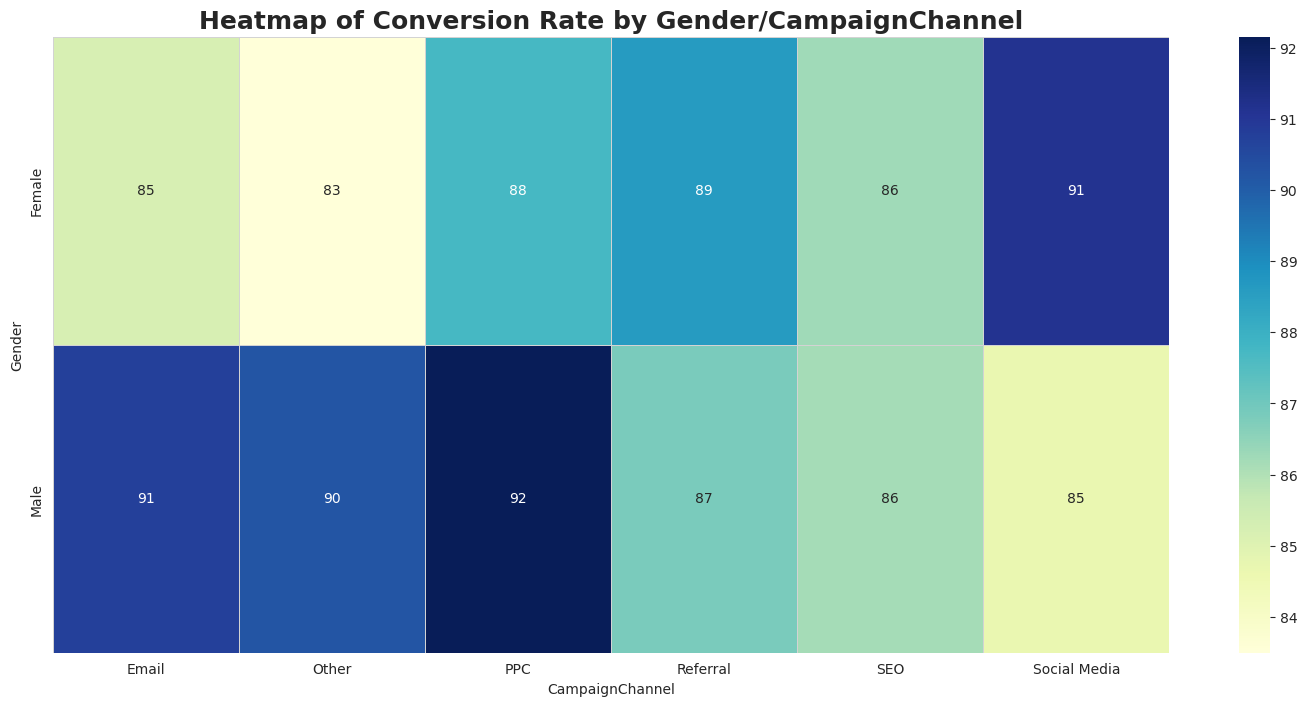

In [219]:
draw_heatmap_groups(df, 'Gender', 'CampaignChannel')

this plot shows that Email, Other, and PPc group are more popular among male costumers, while Social media is the dominant campaing between female costumers. Here we can see that other group is similar to PPC and email groups.

------------

First let's group our costumers based on how loyal they are.

In [220]:
bins = [-1, 1000, 2000, 3000, 4000, 5000]
bin_labels = ['Bronze', 'Silver', 'Gold', 'Platinum', 'Diamond']
categorize_numerical_col('LoyaltyPoints', bins=bins, bins_name=bin_labels)

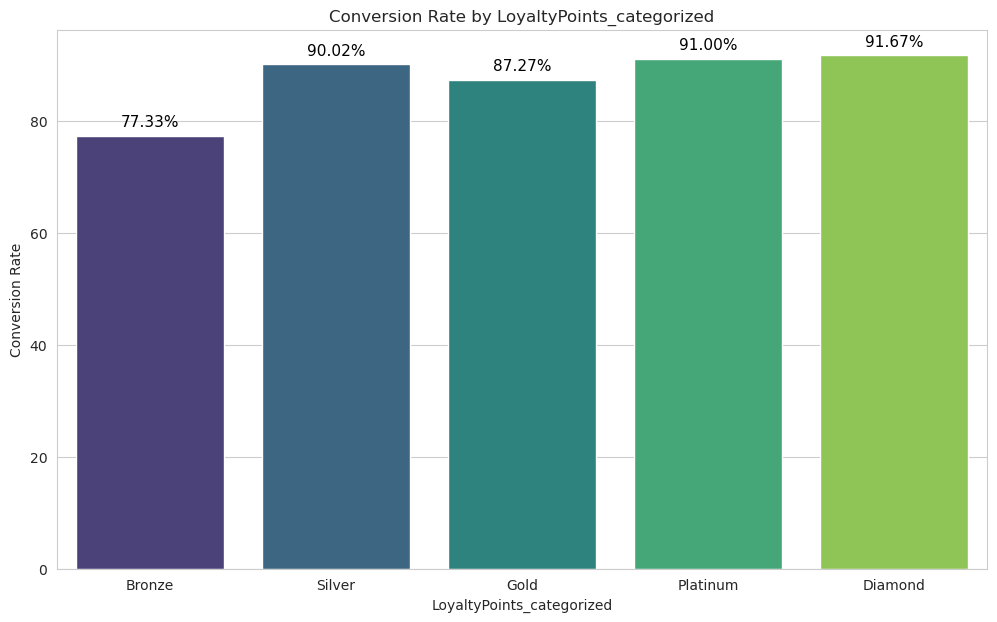

In [221]:
kpi_barplot(df, 'LoyaltyPoints_categorized')

As we can see the plots are generaly increasing (with silver group being an exception).

Let's see how are customers behave in these groups.

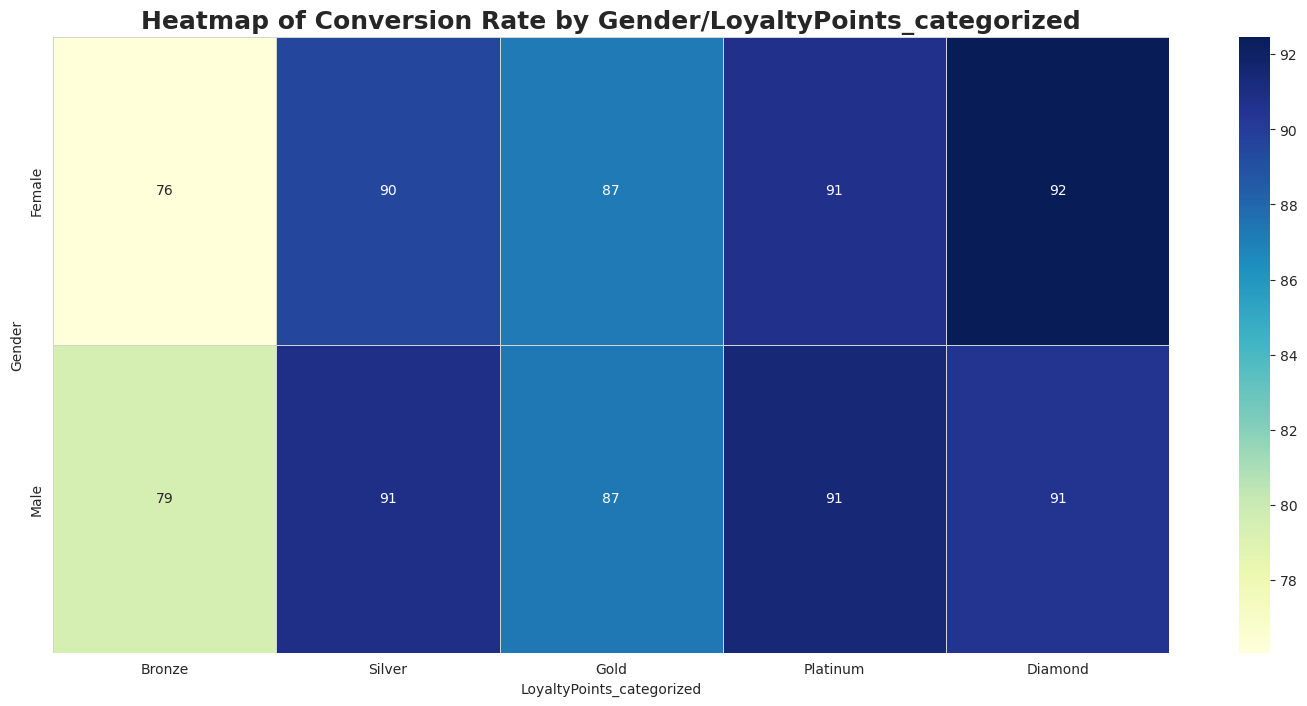

In [222]:
draw_heatmap_groups(df, 'Gender', 'LoyaltyPoints_categorized')

we have fairly similar behavior in each group. something to notice is that new male costumers are more likely to convert than females. we can also see that in Diamond groups female costumers are more likely to convert than male counterparts. this might indicate that female costumers needs more assurance to convert and when they are feeling confident about it they convet more.

Another thing is that services regarding gold customers are not very satisfactory. the conversion rate in this group is lower than both plantnum and silver group.

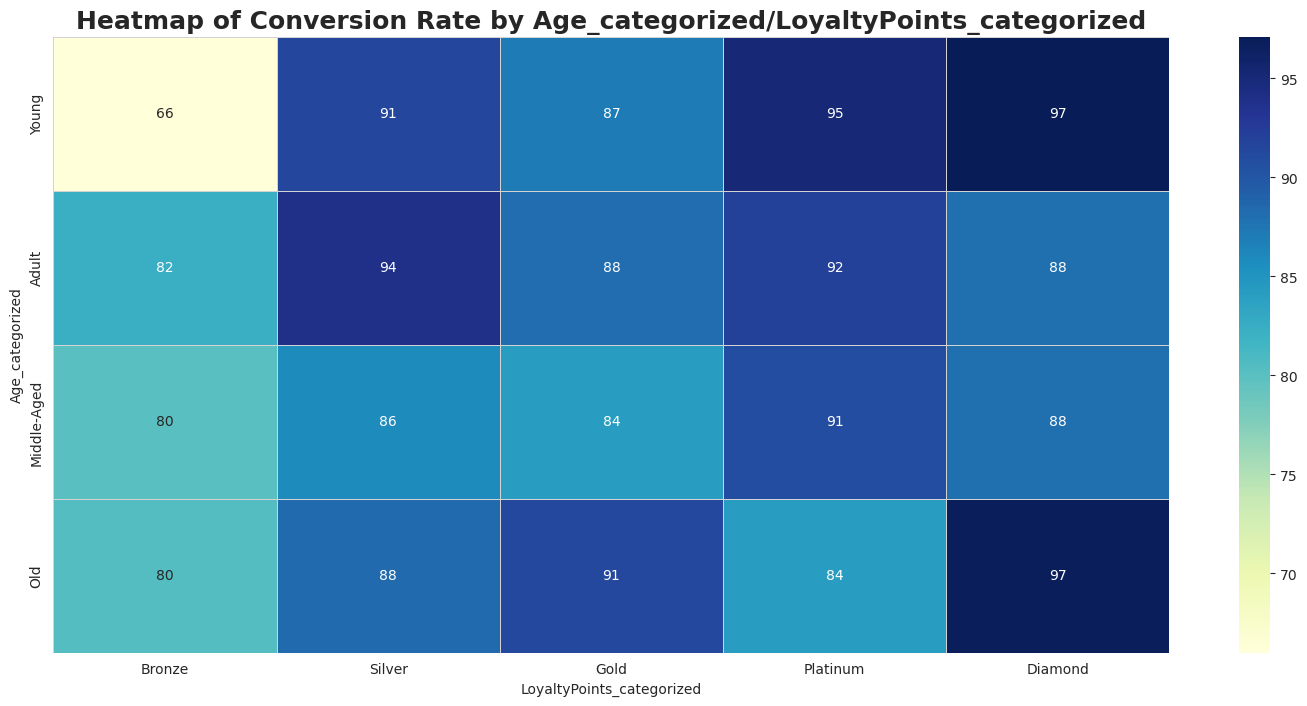

In [223]:
draw_heatmap_groups(df, 'Age_categorized', 'LoyaltyPoints_categorized')

As we can see, the bronze group in the young customers need a lot of work. and also we can see that silver group is very effective with adult. the platinum group is effective most generations but old, and diamond group is effective amoung young and old generations.

---------------

<h1>KPI: Cost Per Conversion (CPC)</h1>

This kpi tells us how much one conversion costs us. or basically how efficient was the group in terms of money spent and conversions gained

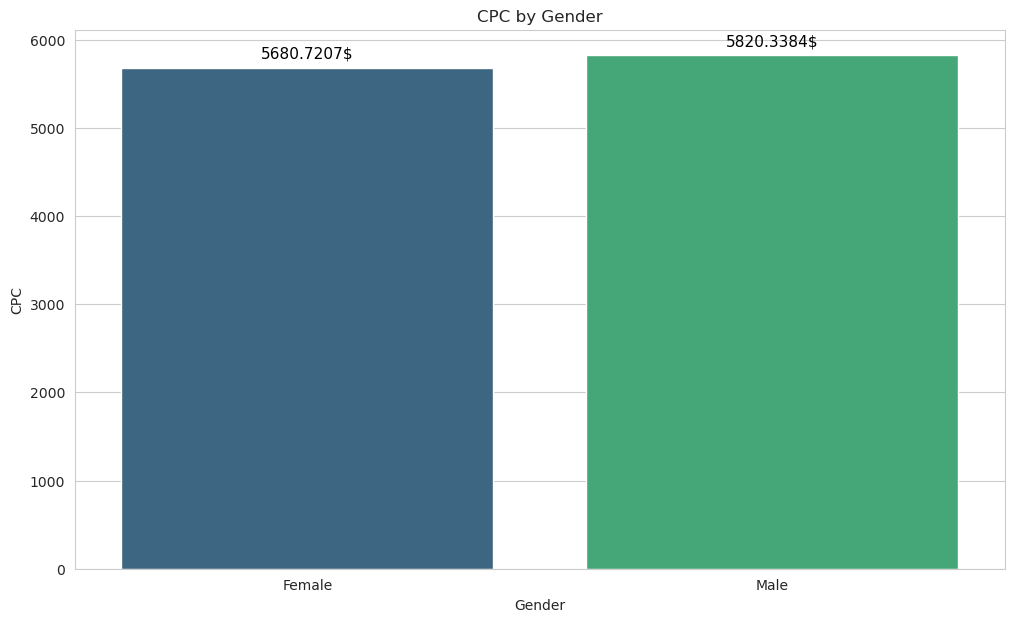

In [245]:
kpi_barplot(df=df, group_col='Gender', kpi='CPC')

This plot shows us that we have spend around 200 $ more for every male customer to convert compared to female costumers. Therefore our male customers are more expensive

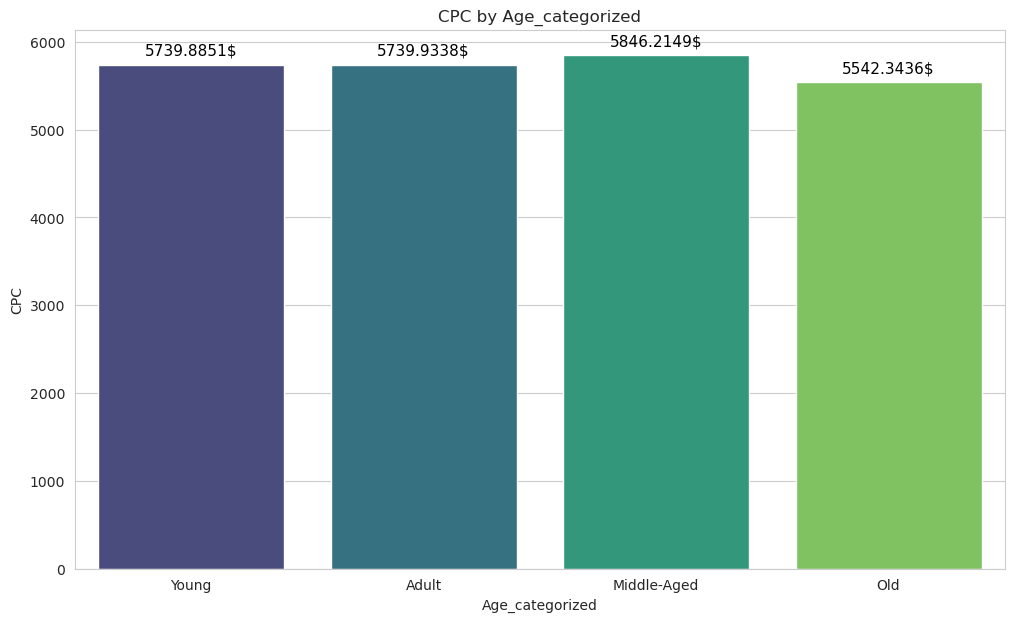

In [246]:
kpi_barplot(df,'Age_categorized', 'CPC')

Groups doesn't differ very much except that old customers costs us less money to convert

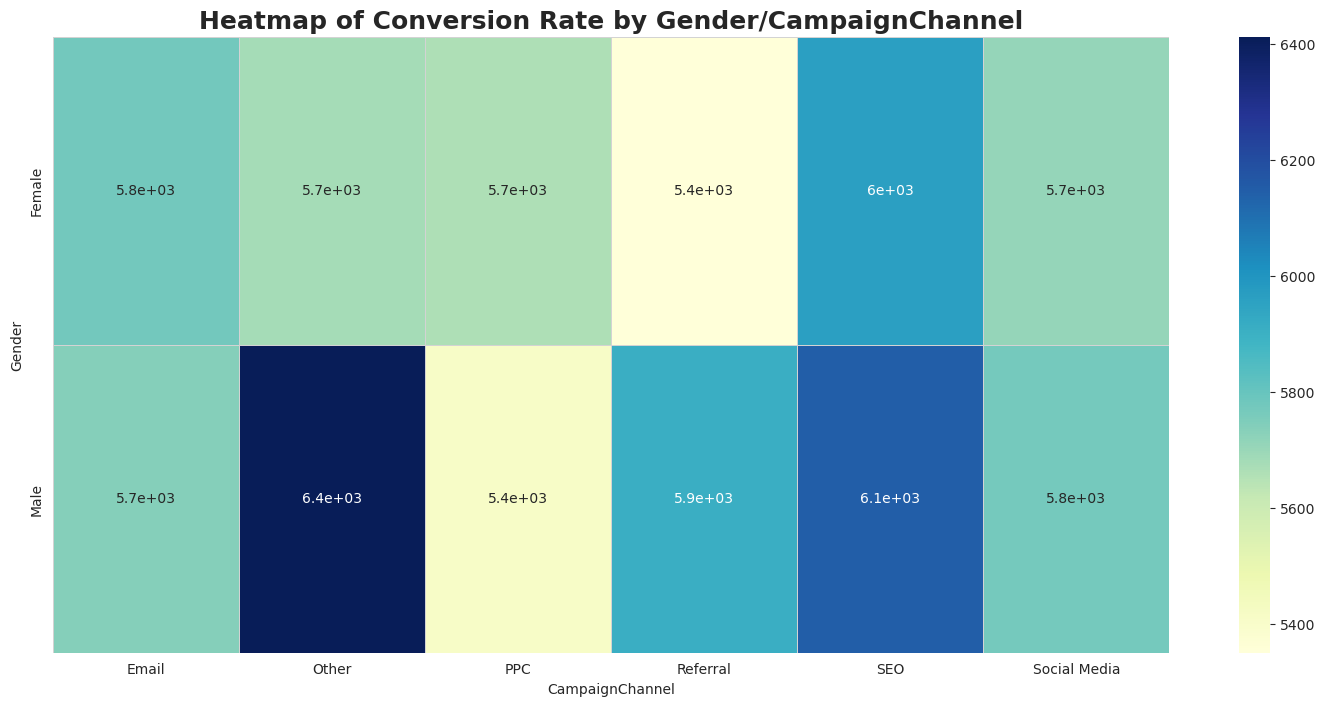

In [247]:
draw_heatmap_groups(df, 'Gender', 'CampaignChannel', 'CPC')

As we can see here PPC is the most efficient campaign channel with male customers and Referral campaign is the most efficient with female costumers. the other group is relatively inefficient in male customers with SEO comes second in both male and female costumers.